Status plot created


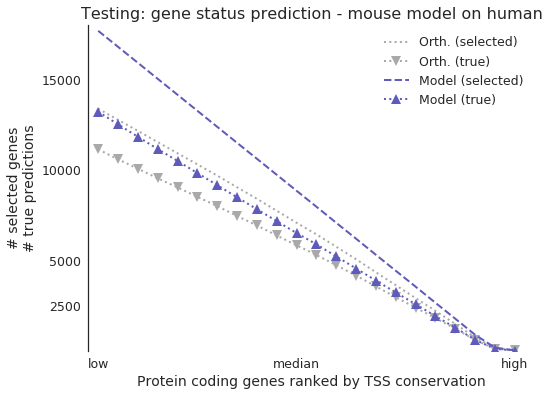

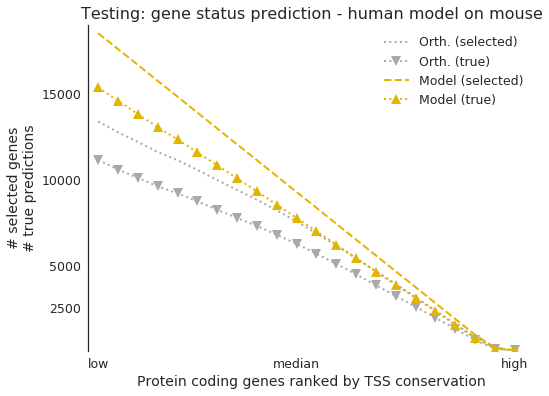

In [50]:
%matplotlib inline

import os as os
import numpy as np
import numpy.random as rng
import json as js
import pickle as pck
import collections as col
import operator as op
import functools as fnt
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from scipy.stats import mannwhitneyu as mwu

sns.set(style='white',
        font_scale=1.25,
        rc={'font.family': ['sans-serif'],
            'font.sans-serif': ['DejaVu Sans']})

fhgfs_base = '/TL/deep/fhgfs/projects/pebert/thesis'
stat_folder = os.path.join(fhgfs_base, 'projects/cross_species/processing/norm/task_summarize')
stat_file = os.path.join(stat_folder, 'agg_expstat_est.h5')
ortho_folder = os.path.join(fhgfs_base, 'projects/cross_species/processing/norm/task_ortho_pred')
ortho_pred = os.path.join(ortho_folder, 'orthopred_odb_6species.h5')

cache_dir = '/home/pebert/.jupyter/cache'

conf_folder = '/home/pebert/work/code/mpggit/crossspecies/graphics'

plot_labels = js.load(open(os.path.join(conf_folder, 'labels', 'cs_labels.json'), 'r'))
plot_colors = js.load(open(os.path.join(conf_folder, 'colors', 'cs_colors.json'), 'r'))
plot_shapes = js.load(open(os.path.join(conf_folder, 'shapes', 'cs_shapes.json'), 'r'))

run_exec_status = True

show_figures = True

out_folder = '/TL/deep-external01/nobackup/pebert/cloudshare/mpiinf/phd/chapter_projects/crossspecies/figures/pub'
save_figures = True

def exec_status():
    cache_data = os.path.join(cache_dir, 'plot_perf_status_line.pck')
    if not run_exec_status:
        return False
    if os.path.isfile(cache_data):
        model_perf = pck.load(open(cache_data, 'rb'))
    else:
        model_perf = collect_ortho_perf(ortho_pred, 'bsig')
        model_perf = collect_model_stat_perf(stat_file, model_perf, 'pos', 'bsig')
        with open(cache_data, 'wb') as out:
            print('Writing cache file for status line plot')
            pck.dump(model_perf, out)
    for (spec_a, spec_b), perf in model_perf.items():
                
        orth_perf = perf['data_orth_pair']['positives'].mean(axis=0).round(decimals=0)
        
        orth_max = perf['data_orth_pair']['relevant'].median(axis=0)
        
        datavalues = [orth_max, orth_perf]
        linecolors = ['darkgrey', 'darkgrey']
        linestyles = ['dotted', 'dotted']
        
        spec_color = plot_colors['species'][spec_b]['rgb']
        model_perf = perf['data_crp_bsig_wg']['positives'].mean(axis=0).round(decimals=0)
        model_max = perf['data_crp_bsig_wg']['relevant'].median(axis=0)
        datavalues.extend([model_max, model_perf])
        
        linecolors.extend([spec_color, spec_color])
        linestyles.extend(['dashed', 'dotted'])
        linelabels = ['Orth. (selected)', 'Orth. (true)', 'Model (selected)', 'Model (true)']
        markershapes = ['', 'v', '', '^']
         
        plot_title = 'Testing: gene status prediction - {} model on {}'.format(spec_a, spec_b)
        
        y_max = datavalues[2].max()
        if np.round(y_max, -3) < y_max:
            y_max = np.round(y_max, -3) + 1000
        else:
            y_max = np.round(y_max, -3)
        
        fig, exart = plot_perf_linechart(datavalues, y_max,
                                         linelabels, linecolors, linestyles,
                                         markershapes,'# selected genes\n# true predictions',
                                         'Protein coding genes ranked by TSS conservation',
                                         plot_title)

        if save_figures:
            outpath = os.path.join(out_folder, 'main', 'fig_X_main_{}-to-{}_testperf_curve.svg'.format(spec_a, spec_b))
            fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight')
            outpath = outpath.replace('.svg', '.png')
            fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight', dpi=300)
    return True
       

def plot_perf_linechart(datavals, ylim, linelabels, linecolor, linestyle, linemarker,
                        ylabel, xlabel, title):
    """
    """    
    fig, ax = plt.subplots(figsize=(8, 6))
    extra_artists = []
    ax.set_xlim(-0.5, datavals[0].size)
    ax.set_ylim(-1, ylim)
    ax.set_yticks([2500, 5000, 10000, 15000])
    ax.set_xticks([0, 10, datavals[0].size - 1])
    ax.set_xticklabels(['low', 'median', 'high'])
    
    x_values = np.arange(datavals[0].size)

    handles = []
    for y_values, label, color, style, marker in zip(datavals,
                                                     linelabels,
                                                     linecolor,
                                                     linestyle,
                                                     linemarker):
        line = ax.plot(x_values, y_values.values, linestyle=style, color=color, marker=marker,
                       markersize=10, linewidth=2, label=label)
        handles.append(line)
        
    handles, labels = ax.get_legend_handles_labels()
    plt.legend()    
    
    extra_artists = []
    
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    return fig, extra_artists


def collect_model_stat_perf(fpath, data_collect, scenario, model_type):
    """
    """
    with pd.HDFStore(fpath, 'r') as hdf:
        load_keys = [k for k in hdf.keys() if k.startswith('/'.join(['', scenario, model_type])) and k.endswith('/cons')]
        for k in load_keys:
            if any([c in k for c in ['GM12878', 'CH12', 'K562', 'MEL']]):
                continue
            md = hdf[k.replace('/cons', '/metadata')]
            spec_a = md.loc['target_spec',:][0]
            spec_b = md.loc['query_spec',:][0]
            perf = hdf[k]
            if (spec_a, spec_b) not in [('human', 'mouse'), ('mouse', 'human')]:
                continue
            model = 'data_crp_{}_wg'.format(model_type)
            if (spec_a, spec_b) not in data_collect:
                data_collect[(spec_a, spec_b)] = {model: {'positives': None,
                                                          'relevant': None}}
            relevant = perf.loc[['relevant'], :]
            positives = perf.loc[['positives'], :]
            
            model_perf = data_collect[(spec_a, spec_b)][model]
            if model_perf['relevant'] is None:
                model_perf['relevant'] = relevant
                model_perf['positives'] = positives
                data_collect[(spec_a, spec_b)][model] = model_perf
            else:
                relevant = pd.concat([model_perf['relevant'], relevant], ignore_index=True, axis=0)
                positives = pd.concat([model_perf['positives'], positives], ignore_index=True, axis=0)
                model_perf['relevant'] = relevant
                model_perf['positives'] = positives
                data_collect[(spec_a, spec_b)][model] = model_perf
    return data_collect


def collect_ortho_perf(fpath, model):
    """
    """
    collector = dict()
    with pd.HDFStore(fpath, 'r') as hdf:
        load_keys = [k for k in hdf.keys() if k.startswith('/pos/pair') and k.endswith('/cons')]
        for k in load_keys:
            if any([c in k for c in ['GM12878', 'CH12', 'K562', 'MEL']]):
                continue
            parts = k.split('/')
            spec_a, spec_b = parts[3], parts[4]
            if (spec_a, spec_b) not in [('mouse', 'human'), ('human', 'mouse')]:
                continue
            perf = hdf[k]
            if (spec_a, spec_b) not in collector:
                collector[(spec_a, spec_b)] = {'data_orth_pair': {'relevant': None,
                                                                  'positives': None},
                                               'data_crp_{}_wg'.format(model): {'positives': None,
                                                                                'relevant': None}}
            relevant = perf.loc[['relevant'], :]
            positives = perf.loc[['positives'], :]
            
            orth_perf = collector[(spec_a, spec_b)]['data_orth_pair']
            if orth_perf['relevant'] is None:
                orth_perf['relevant'] = relevant
                orth_perf['positives'] = positives
                collector[(spec_a, spec_b)]['data_orth_pair'] = orth_perf
            else:
                relevant = pd.concat([orth_perf['relevant'], relevant], ignore_index=True, axis=0)
                positives = pd.concat([orth_perf['positives'], positives], ignore_index=True, axis=0)
                orth_perf['relevant'] = relevant
                orth_perf['positives'] = positives
                collector[(spec_a, spec_b)]['data_orth_pair'] = orth_perf
    return collector               
                

execd = exec_status()
if execd:
    print('Status plot created')